In [15]:
# Imports
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.datasets import fetch_401K

import torch
from torch import nn
import os
import time
from functools import partial

# Causal_cocycle imports
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.optimise_new import validate
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.model_new import ZukoCocycleModel
from e401k_cocycle_config import opt_config
from architectures import get_stock_transforms

In [12]:
# Getting data and names
Data = fetch_401K(return_type='DataFrame')
data = Data.to_numpy()
names = np.array(list(Data[:0]))

In [13]:
"""
Data processing
"""
# Names
covariates = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown', 'e401']
treatment = ["e401"]
outcome = ["net_tfa"]

# Creating tensors
X = Data[Data.columns.intersection(covariates)]
names_x = np.array(list(X[:0]))
treatment_ind = np.where(names_x == "e401")[0][0]
X = X.to_numpy()
cols_order = ([treatment_ind]+
              list(np.linspace(0,treatment_ind-1,treatment_ind).astype(int))+
              list(np.linspace(treatment_ind+1,len(X.T)-1,len(X.T)-1-treatment_ind).astype(int)))
X = X[:,cols_order]
N = len(X)
D = len(X.T)
Y = Data[Data.columns.intersection(outcome)].to_numpy().reshape(N,)
X,Y = torch.tensor(X),torch.tensor(Y).view(N,1)
print("# treated = ", int(X[:,0].sum()), "/", N)

# Scaling data
scale_X = torch.ones(len(X.T))
for i in range(len(X.T)):
    if len(torch.unique(X[:,i])) > 2:
        scale_X[i] = X[:,i].var(0)**0.5
scale_Y = Y.var(0)**0.5
Xscale,Yscale = X/scale_X, Y/scale_Y

# Random dataset shuffle
id = torch.randperm(Xscale.size(0))
Xscale,Yscale = Xscale[id],Yscale[id]

# Train validation split
train_pc = 1.0
ntrain = int(train_pc * N)
Xtr, Ytr = Xscale[:ntrain], Yscale[:ntrain]
Xte, Yte = Xscale[ntrain:], Yscale[ntrain:]

Xscale.mean(0), Yscale.mean()

# treated =  3682 / 9915


(tensor([0.3714, 3.9693, 1.5016, 1.8622, 4.6991, 0.2710, 0.6048, 0.3808, 0.2422,
         0.6352]),
 tensor(0.2842))

In [22]:
# Build architectures
transforms = get_stock_transforms(x_dim = D, y_dim = 1)

# Cocycle models
cocycle_models = [ZukoCocycleModel(nn.ModuleList(t)) for t in transforms]

# Set up loss factories
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)

# Cross-validate each family
hyper_kwargs = [{'learn_rate': 1e-2}] * (len(cocycle_models)-1) + [{'learn_rate': 1e-3}] 
cmmdv = loss_factory.build_loss("CMMD_V", Xtr, Ytr)
final_v, (idx_v, _) = validate(cocycle_models, cmmdv, Xtr, Ytr, method="CV",
                               train_val_split=0.5, opt_kwargs=opt_config,
                               hyper_kwargs=hyper_kwargs, choose_best_model="overall", retrain=True)

Epoch 1/1000, Training Loss: -0.3908
Epoch 2/1000, Training Loss: -0.4767
Epoch 3/1000, Training Loss: -0.4779
Epoch 4/1000, Training Loss: -0.4753
Epoch 5/1000, Training Loss: -0.4725
Epoch 6/1000, Training Loss: -0.4633
Epoch 7/1000, Training Loss: -0.4788
Epoch 8/1000, Training Loss: -0.4883
Epoch 9/1000, Training Loss: -0.4789
Epoch 10/1000, Training Loss: -0.4749
Epoch 11/1000, Training Loss: -0.4722
Epoch 12/1000, Training Loss: -0.4804
Epoch 13/1000, Training Loss: -0.4773
Epoch 14/1000, Training Loss: -0.4792
Epoch 15/1000, Training Loss: -0.4786
Epoch 16/1000, Training Loss: -0.4738
Epoch 17/1000, Training Loss: -0.4709
Epoch 18/1000, Training Loss: -0.4708
Epoch 19/1000, Training Loss: -0.4911
Epoch 20/1000, Training Loss: -0.4856
Epoch 21/1000, Training Loss: -0.4816
Epoch 22/1000, Training Loss: -0.4778
Epoch 23/1000, Training Loss: -0.4924
Epoch 24/1000, Training Loss: -0.4802
Epoch 25/1000, Training Loss: -0.4865
Epoch 26/1000, Training Loss: -0.4832
Epoch 27/1000, Traini

In [23]:
"""
Getting predicted counterfactuals
"""
final_model_overall = final_v
X0scale,X1scale = Xscale*1,Xscale*1
X0scale[:,0] = 0
X1scale[:,0] = 1
Y0scale = final_model_overall.cocycle(X0scale,Xscale,Yscale).detach()
Y1scale = final_model_overall.cocycle(X1scale,Xscale,Yscale).detach()

ATE = (Y1scale-Y0scale).mean()*scale_Y
ATT = (Y1scale[Xscale[:,0]==1]-Y0scale[Xscale[:,0]==1]).mean()*scale_Y
print("ATE : ", ATE.item())
print("ATT : ", ATT.item())

ATE :  9380.1328125
ATT :  12140.3798828125


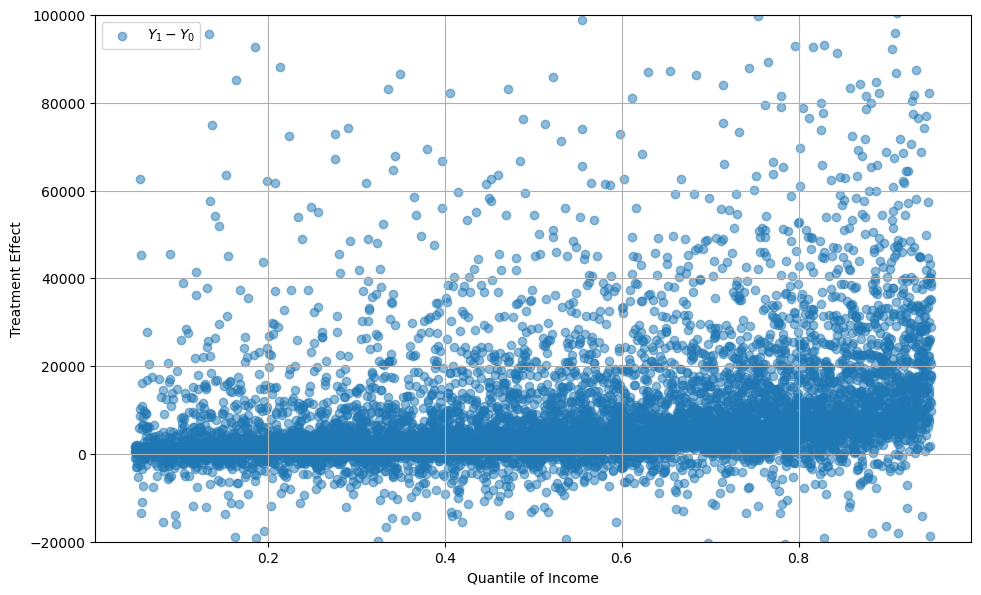

In [25]:
"""
Treatment effect vs Income quantile
"""
n = N
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
V = Xscale[:,2:3]
scale_V = scale_X[2:3]
sort_idx = np.argsort(V.squeeze(-1))
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
quantile_positions = np.linspace(0, 1, N)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", alpha = 0.5)
plt.xlabel("Quantile of Income")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.tight_layout()
#plt.yscale("log")
plt.ylim(-20000,100000)
plt.legend()
plt.show()

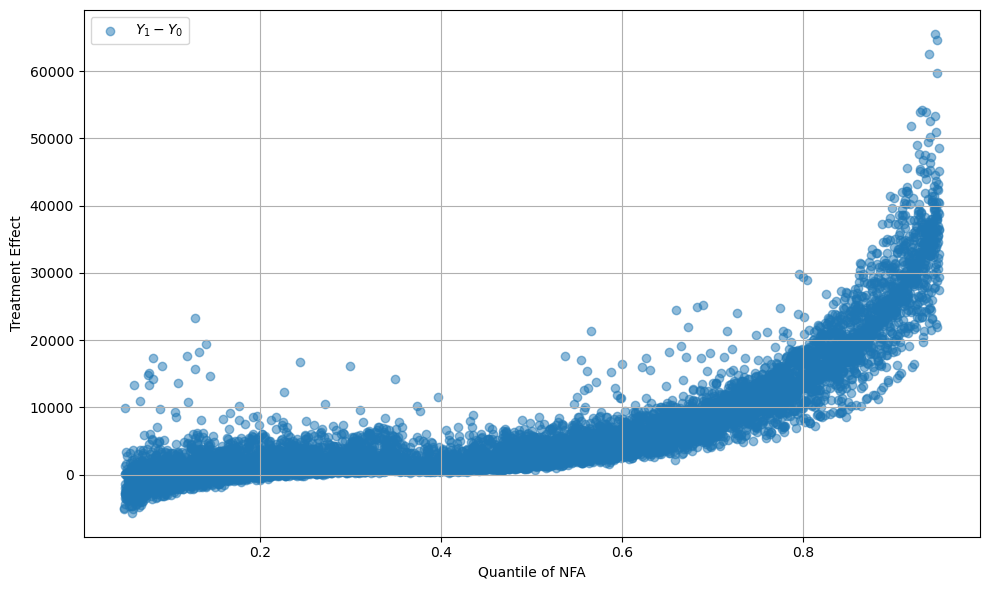

In [26]:
"""
Treatment effect vs NFA(0) quantile
"""
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
sort_idx = np.argsort(Y0scale.squeeze(-1))
Y0_sorted = Y0scale[sort_idx]
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
n = len(Y0scale)
quantile_positions = np.linspace(0, 1, n)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", alpha = 0.5)
plt.xlabel("Quantile of NFA")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [36]:
"""
Train Nadaraya Watson Regressor for conditional distribution of treatment effect 
"""
kernel_V = GaussianKernel(lengthscale=torch.ones(1))
functional_V = NWFunctional(kernel=kernel_V, reg=0.0)
CER_V = ConditionalExpectationRegressor(functional_V)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100))
feature_ = (Y1scale - Y0scale<= test_points_.unsqueeze(0)).float()
losses_V = CER_V.optimise(V.argsort(0).argsort(0)/N, feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

kernel_Y0 = GaussianKernel(lengthscale=torch.ones(1))
functional_Y0 = NWFunctional(kernel=kernel_Y0, reg=0.0)
CER_Y0 = ConditionalExpectationRegressor(functional_Y0)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100))
feature_ = (Y1scale - Y0scale<= test_points_.unsqueeze(0)).float()
losses_Y0 = CER_Y0.optimise(Y0scale.argsort(0).argsort(0)/N, feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.159856
lengthscale: tensor([0.9048], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.141433
lengthscale: tensor([0.3264], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.129715
lengthscale: tensor([0.1320], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.129340
lengthscale: tensor([0.0820], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.129751
lengthscale: tensor([0.0688], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.129728
lengthscale: tensor([0.0683], grad_fn=<ExpBackward0>)
[iter 60] avg CV loss: 0.130030
lengthscale: tensor([0.0725], grad_fn=<ExpBackward0>)
[iter 70] avg CV loss: 0.129289
lengthscale: tensor([0.0781], grad_fn=<ExpBackward0>)
[iter 80] avg CV loss: 0.129249
lengthscale: tensor([0.0817], grad_fn=<ExpBackward0>)
[iter 90] avg CV loss: 0.129160
lengthscale: tensor([0.0844], grad_fn=<ExpBackward0>)
[iter 100] avg CV loss: 0.129277
lengthscale: tensor([0.0862], grad_fn=<ExpBackward0>)
[iter 110] avg

In [37]:
""" 
Predicting conditional quantiles of treatment effect (given quantiles of conditioning variable)
"""
ntest = 500
quantiles = torch.tensor([[0.025,0.05,0.25,0.5,0.75,0.95,0.975]]).T
diff_sorted,ids = (Y1scale-Y0scale).squeeze(-1).sort()
Y0sorted = Y0scale[ids]
Vsorted = V[ids]

conditioner_V = NWConditioner(Vsorted.argsort(0).argsort(0)/N, kernel_V)
conditioner_Y0 = NWConditioner(Y0sorted.argsort(0).argsort(0)/N, kernel_Y0)
transformer_ = KREpsLayer(diff_sorted, epsilon = 0)

Y0test = torch.linspace(0.1,0.9,ntest).unsqueeze(-1)
Vtest = torch.linspace(0.1,0.9,ntest).unsqueeze(-1)
weights_V = conditioner_V.forward(Vtest)
weights_Y0 = conditioner_Y0.forward(Y0test)
quantile_preds_V = torch.zeros((len(quantiles),ntest))
quantile_preds_Y0 = torch.zeros((len(quantiles),ntest))
for i in range(ntest):
    quantile_preds_V[:,i] = transformer_.forward(weights_V[i:i+1].repeat(len(quantiles),1), quantiles)
    quantile_preds_Y0[:,i] = transformer_.forward(weights_Y0[i:i+1].repeat(len(quantiles),1), quantiles)

mu_preds_V = functional_V.forward(Y1scale-Y0scale,V.argsort(0).argsort(0)/N, torch.linspace(0.1,0.9,ntest).unsqueeze(-1))
mu_preds_Y0 = functional_Y0.forward(Y1scale-Y0scale,Y0scale.argsort(0).argsort(0)/N, torch.linspace(0.1,0.9,ntest).unsqueeze(-1))

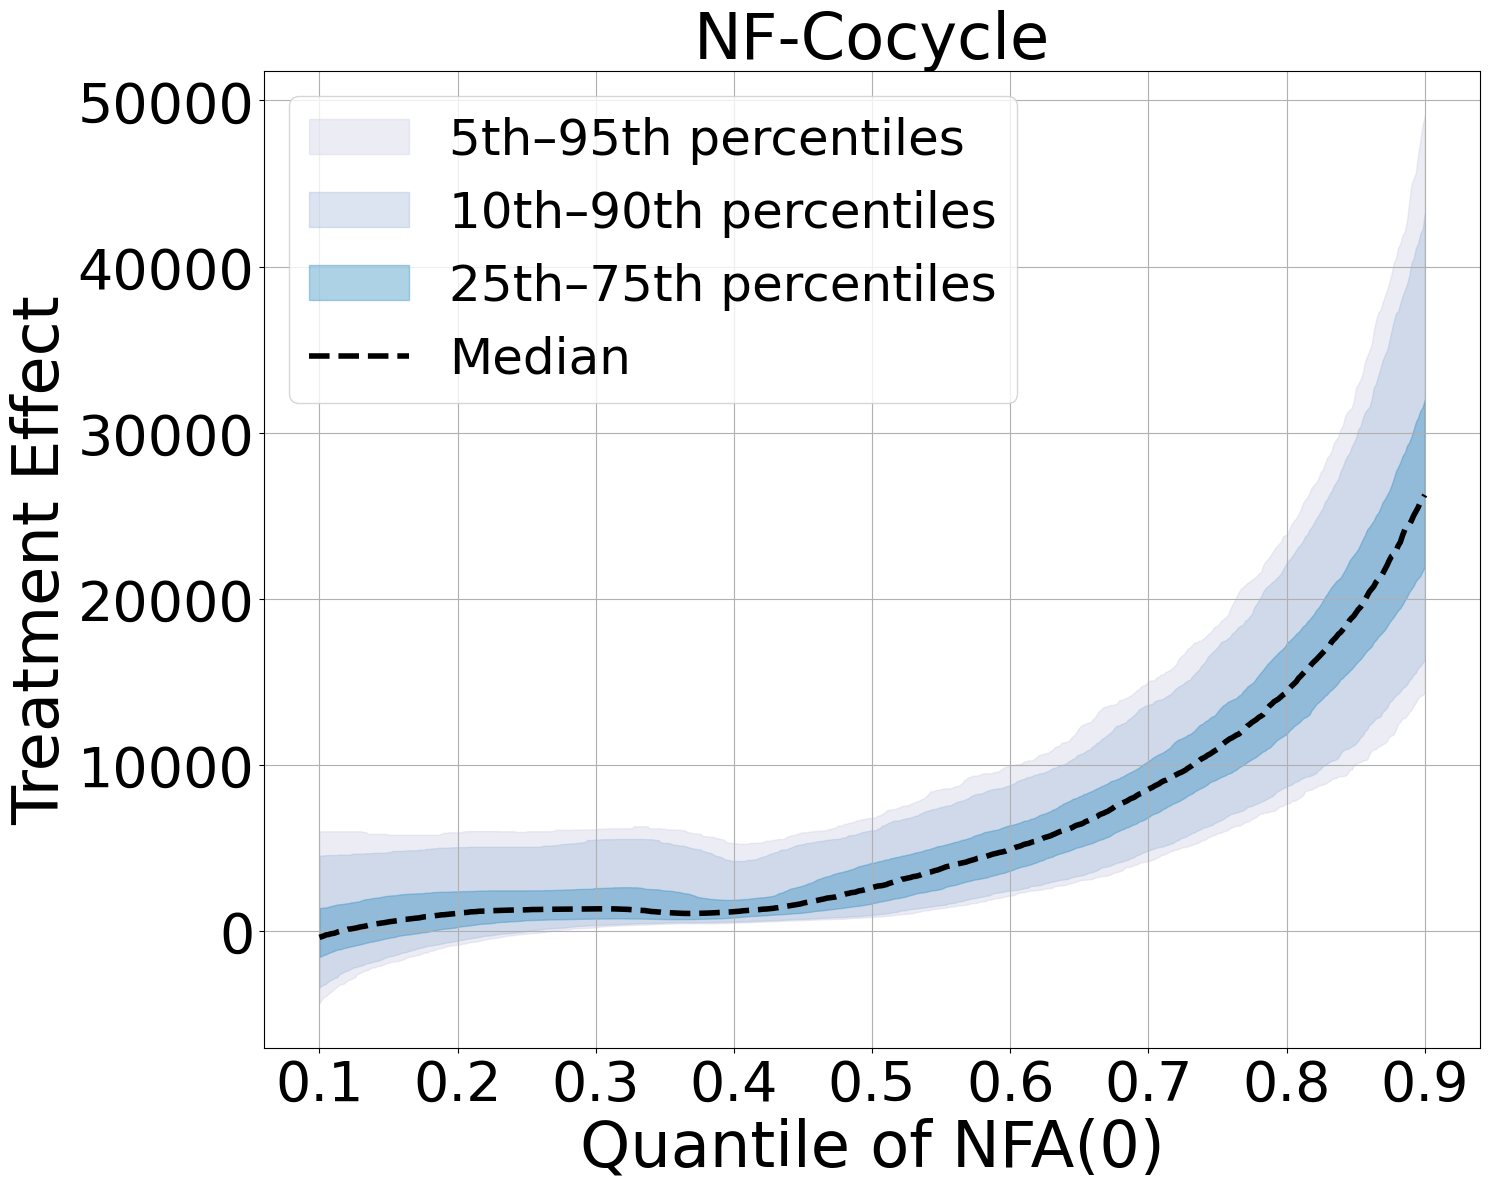

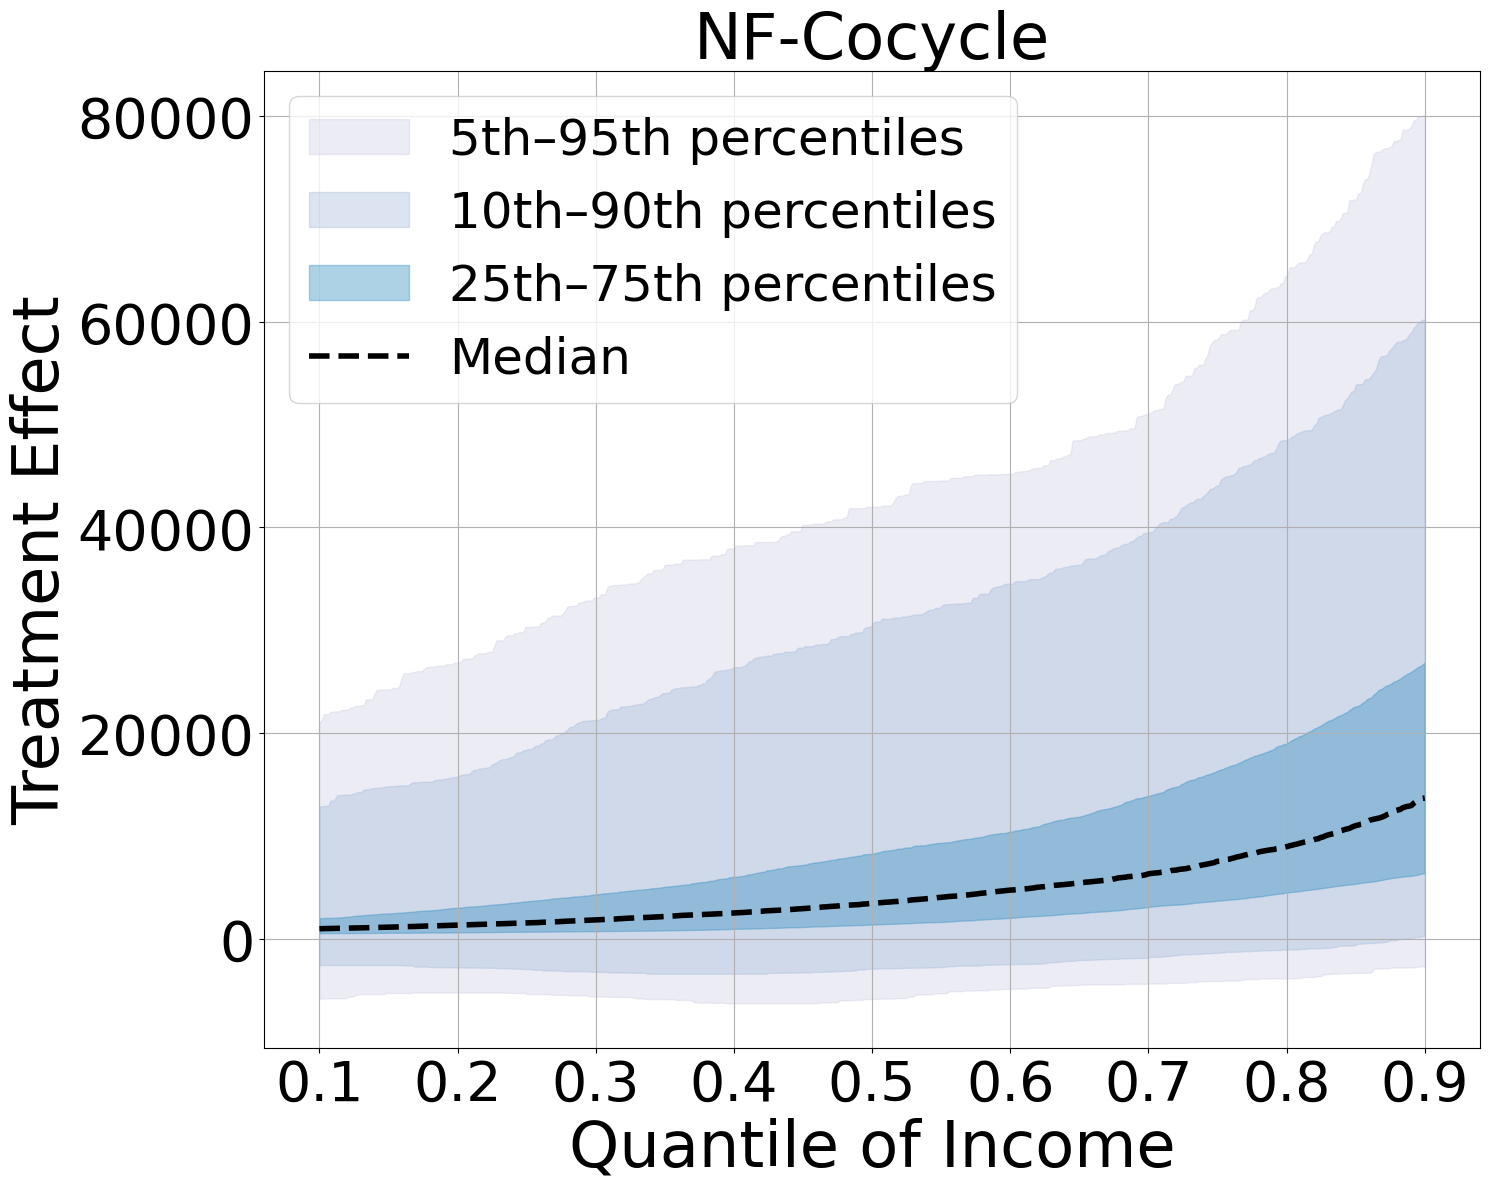

In [49]:
"""
Plotting Results
"""
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds_Y0.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.05, 0.95), (0.1, 0.9), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int(lo*100)}th–{int(hi*100)}th percentiles')

# Add the median quantile curve
plt.plot(x,qmap[0.5]*scale_Y.item(), color='black', lw=4.0, label='Median', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of NFA(0)', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'NF-Cocycle', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_nfcocycle_NFA.png", bbox_inches = "tight")
plt.show()

"""
Plotting Results
"""
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds_V.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.05, 0.95), (0.1, 0.9), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

ind = 0
for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int(lo*100)}th–{int(hi*100)}th percentiles')

# Add the median quantile curve
plt.plot(x,qmap[0.5]*scale_Y.item(), color='black', lw=4.0, label='Median', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of Income', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'NF-Cocycle', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_nfcocycle_income.png", bbox_inches = "tight")
plt.show()